In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from zlib import crc32

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import  BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV

#### loading housing dataset

In [2]:
def load_data(path='dataset/housing.csv') -> pd.DataFrame:
    return pd.read_csv(path)

In [3]:
housing = load_data()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


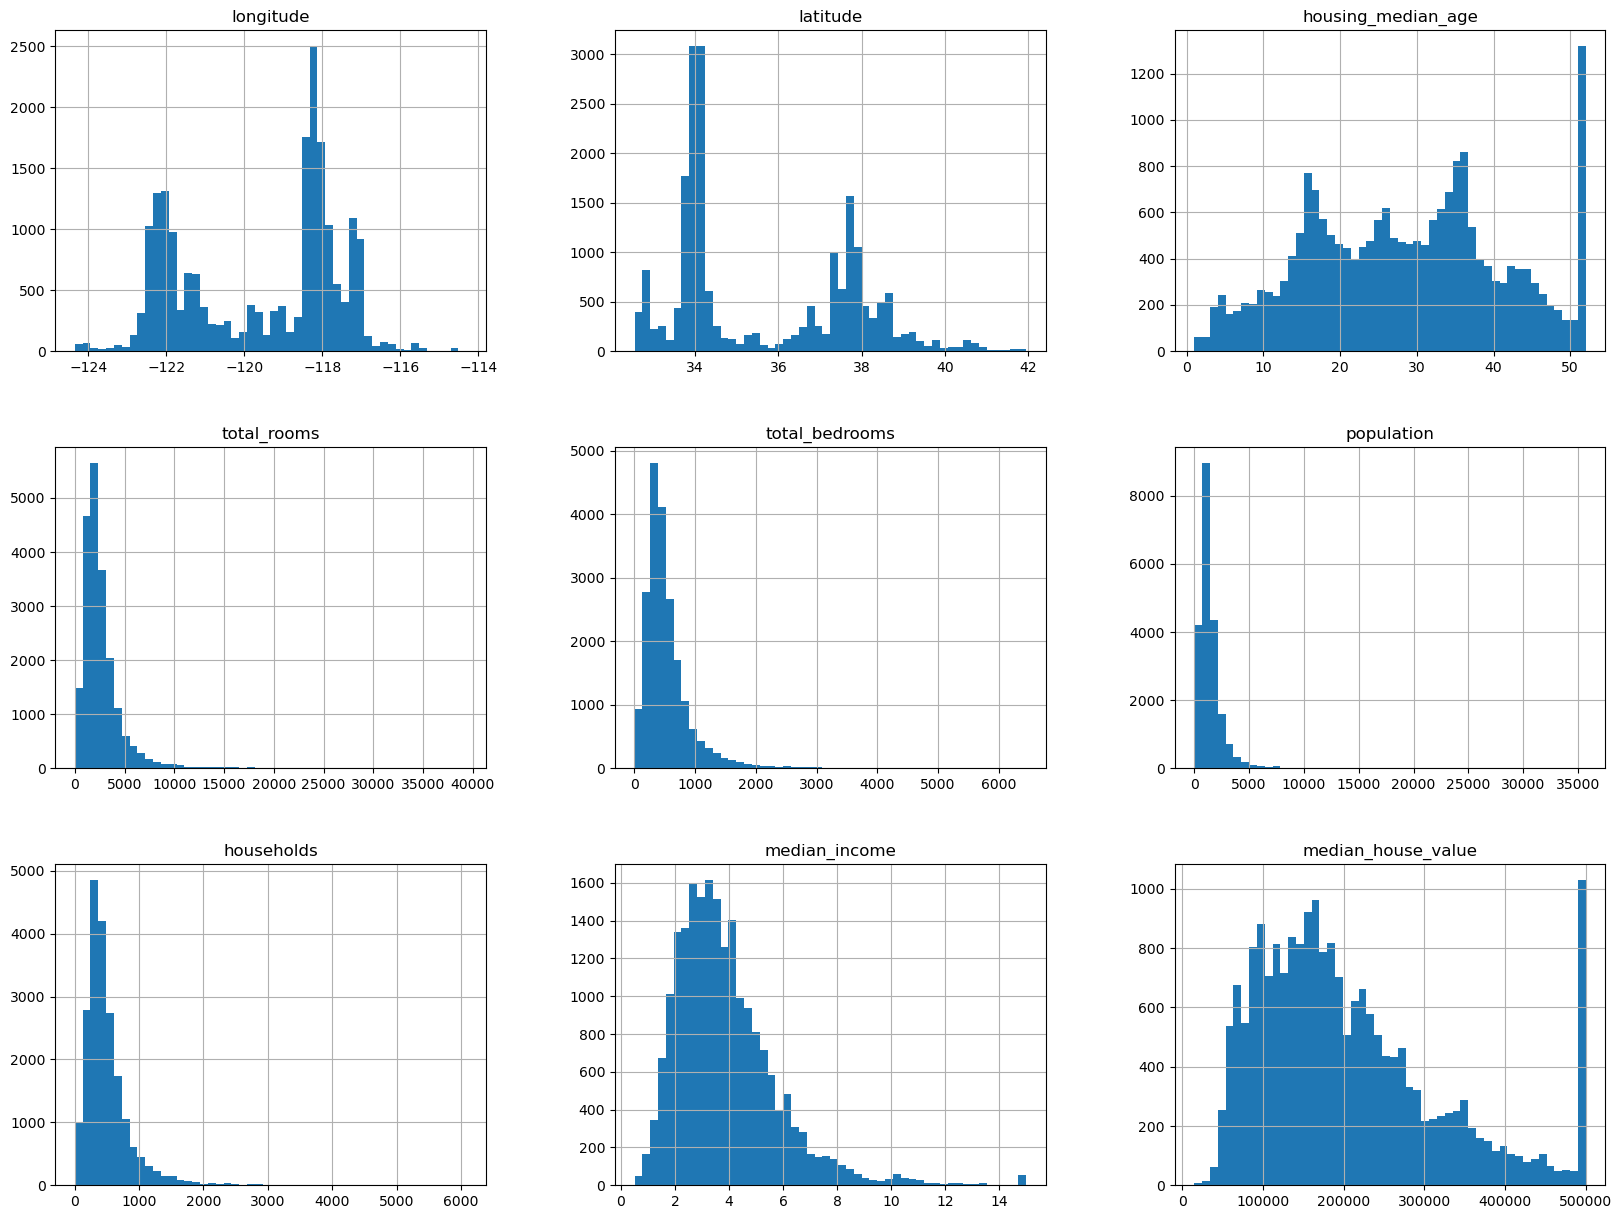

In [5]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

###  split data into test & train

##### custom

In [6]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [7]:
def custom_split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]



housing_with_id = housing.reset_index()
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

In [8]:
custom_train_set, custom_test_set = custom_split_train_test_by_id(housing_with_id, 0.2, "index")
print(len(custom_train_set))
print(len(custom_test_set))


16512
4128


#### using sklearn 

In [9]:
sk_train_set, sk_test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(sk_train_set))
print(len(sk_test_set))

16512
4128


###### considering stratified sampling wrt median income

<Axes: >

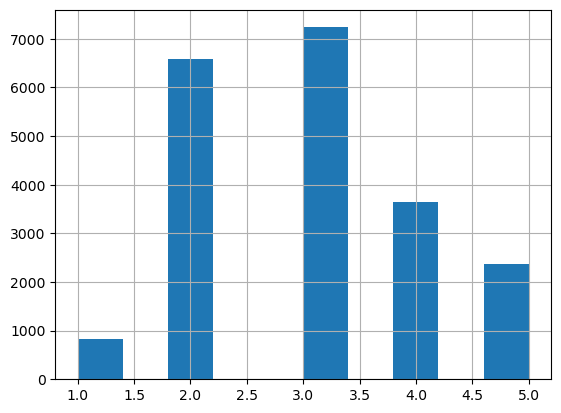

In [10]:
housing['income_cat'] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

#### discover and Visualize data to gain insights

In [12]:
# working with the train set ony
housing = strat_train_set.copy()


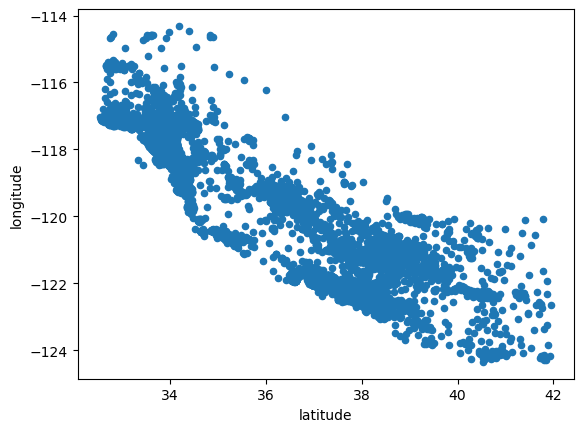

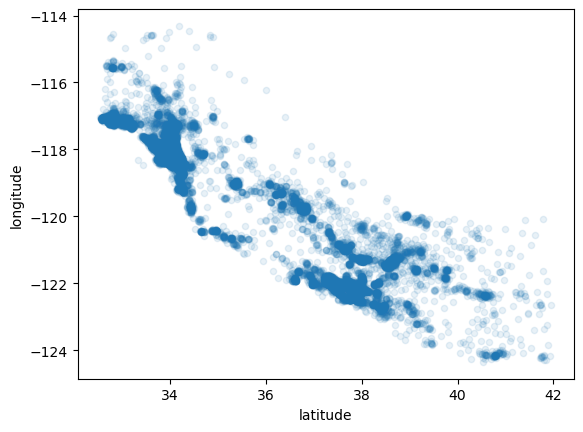

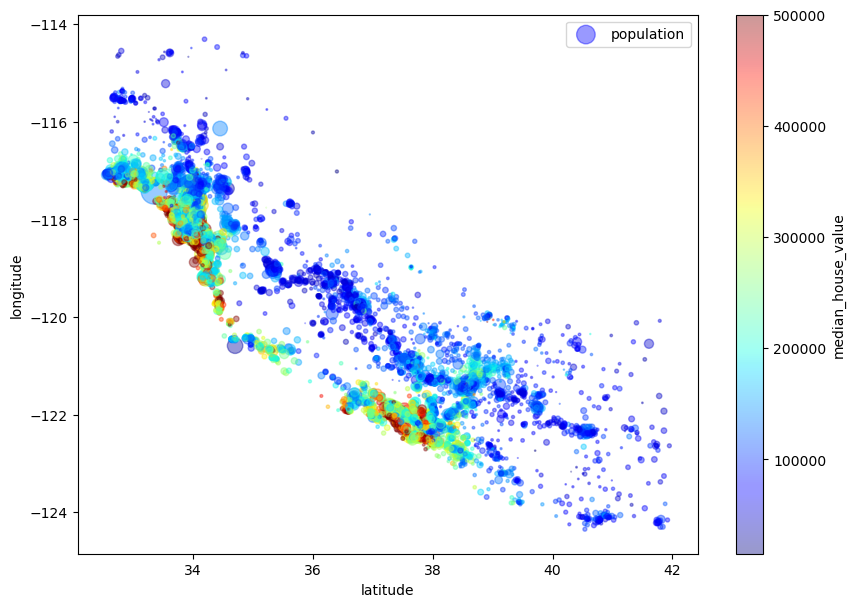

In [13]:
# visualizing geographical data

housing.plot(kind="scatter", y="longitude", x="latitude")
housing.plot(kind="scatter", y="longitude", x="latitude", alpha=0.1)

housing.plot(kind="scatter", y="longitude", x="latitude", alpha=0.4, s=housing["population"]/100, label="population"
             , figsize=(10, 7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()


#### looking for correlations (Pearson's)

In [14]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

C:\Users\Acer\AppData\Local\Temp\ipykernel_952\826279322.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

#### Experimenting with Attribute Combinations

In [15]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

C:\Users\Acer\AppData\Local\Temp\ipykernel_952\731844058.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

### Preparing data for ML Algo.

In [16]:
housing = strat_train_set.drop("median_house_value", axis=1)

housing_labels = strat_train_set["median_house_value"].copy()

#### data cleaning 

In [17]:
# housing.dropna(subset=["total_bedrooms"]) # option 1
# housing.drop("total_bedrooms", axis=1)      # option 2
median = housing["total_bedrooms"].median()   # option 3

housing["total_bedrooms"].fillna(median, inplace=True)

#### handling text and categorical attributes

In [18]:
housing_cat = housing[["ocean_proximity"]]

housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [19]:
# converting categories from text to numbers (normal encodings)

ordinal_encoder = OrdinalEncoder()
housing_cat_encoder = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoder[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [20]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [21]:
# using one hot encoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#### custom transformations

In [22]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room =  add_bedrooms_per_room

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 2, 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 5, 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 2, 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., 3, 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., 3, 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 3, 5.477157360406092,
        3.1725888324873095]], dtype=object)

### Feature scaling and Transformations

##### lets put everything together thus, redo some of the procedures using pipelines to implement missing data (imputations), Attribute Addition 

In [23]:
housing_num = housing.drop("ocean_proximity", axis=1)


In [24]:
num_pipline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())   ## transformation (feature scaling)
])

housing_num_tr = num_pipline.fit_transform(housing_num) # this only considered the number columns

#  to transform the whole data we consider not only the numeric columns but also  the category column.

In [25]:
## columns transformation on numeric and category column

num_attribs = list(housing_num)
cat_attibs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipline, num_attribs),   
    ("cat", OneHotEncoder(), cat_attibs)
])

housing_prepared = full_pipeline.fit_transform(housing)

### Select and Train a Model

#### trying linear regression

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [27]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [ 83811.08312039 314388.27147935 145641.85902864 183704.64921202
 238729.66725745]
Labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [28]:
# RMSE

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse  # value totally not correct

68376.51254853733

#### trying decision tree regressor

In [29]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print('check rmse: ', tree_rmse)  # overfitting, lets do a  cross-validate




##cross-validations
## cross validation by fold method

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

display_scores(tree_rmse_scores)  # decistion tree performed worse

check rmse:  0.0
Scores:  [72520.10353181 70639.05653499 68925.64919318 71318.12731266
 70022.08677191 77569.20649678 69305.86009257 73821.35551877
 69111.32256559 71476.5254195 ]
Mean:  71470.92934377816
Standard deviation:  2517.191111453533


#### trying Random forest regressor

In [30]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_housing_predictions)
forest_rmse = np.sqrt(forest_mse)

print('check rmse: ', forest_rmse) 




##cross-validations
## cross validation by fold method

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores) 

check rmse:  18629.216602482717
Scores:  [51204.00967609 49108.11910334 47270.99817309 52128.26347103
 47558.91764311 51947.3112671  52018.25242719 49649.53261048
 49021.80476259 53653.09366445]
Mean:  50356.03027984804
Standard deviation:  2029.8646591460981


#### Fine-Tuning the Model

In [33]:
## Grid search

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

grid_search = GridSearchCV(forest_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [35]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [37]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63607.50407887263 {'max_features': 2, 'n_estimators': 3}
56133.45895061765 {'max_features': 2, 'n_estimators': 10}
53056.40436815009 {'max_features': 2, 'n_estimators': 30}
61399.446113934166 {'max_features': 4, 'n_estimators': 3}
53618.12363096361 {'max_features': 4, 'n_estimators': 10}
51497.576018496045 {'max_features': 4, 'n_estimators': 30}
60128.83072731206 {'max_features': 6, 'n_estimators': 3}
53177.019168689374 {'max_features': 6, 'n_estimators': 10}
50926.14850494695 {'max_features': 6, 'n_estimators': 30}
59812.47111728172 {'max_features': 8, 'n_estimators': 3}
53052.04569203351 {'max_features': 8, 'n_estimators': 10}
50818.70618629347 {'max_features': 8, 'n_estimators': 30}
62853.626467477734 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54717.167269731166 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60904.46262241181 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53012.329566309076 {'bootstrap': False, 'max_features': 3, 'n_estimator

#### Analyze best models and their errors

In [47]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.10056411e-02, 5.59088572e-02, 4.44271654e-02, 1.58606546e-02,
       1.60947899e-02, 1.57526158e-02, 1.55482991e-02, 3.30444586e-01,
       1.12873595e-01, 3.58117497e-02, 1.13105355e-01, 3.60567418e-02,
       4.43129551e-03, 1.37321131e-01, 1.33342528e-04, 2.22930281e-03,
       2.99487848e-03])

In [48]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3304445858334063, 'median_income'),
 (0.13732113065427085, 'INLAND'),
 (0.11310535453392022, 'pop_per_hhold'),
 (0.11287359497353662, 'income_cat'),
 (0.06100564109060189, 'longitude'),
 (0.05590885716432854, 'latitude'),
 (0.044427165442722974, 'housing_median_age'),
 (0.03605674179378628, 'bedrooms_per_room'),
 (0.03581174974235367, 'rooms_per_hhold'),
 (0.016094789944175982, 'total_bedrooms'),
 (0.01586065456274454, 'total_rooms'),
 (0.015752615812747478, 'population'),
 (0.015548299124913496, 'households'),
 (0.0044312955106138455, '<1H OCEAN'),
 (0.0029948784787532127, 'NEAR OCEAN'),
 (0.0022293028089474657, 'NEAR BAY'),
 (0.00013334252817670644, 'ISLAND')]

#### Evaluation

In [56]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [59]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

49068.61782785059


In [60]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(),
                          scale=stats.sem(squared_errors)))

array([47041.42710083, 51015.3177721 ])